In [1]:
import os, warnings, pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest


In [2]:
df = pd.read_csv("/datasets/logs_exp_us.csv", sep="\t")

In [3]:
# Renombrar columnas 
df = df.rename(columns={
    'EventName':'event',
    'DeviceIDHash':'user_id',
    'EventTimestamp':'timestamp',
    'ExpId':'exp_id'
})

# Convertir a datetime
df['event_datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df['event_date'] = df['event_datetime'].dt.date

# Comprobar ausentes
display(df.info())
display(df.isna().mean().to_frame('missing_ratio').T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event           244126 non-null  object        
 1   user_id         244126 non-null  int64         
 2   timestamp       244126 non-null  int64         
 3   exp_id          244126 non-null  int64         
 4   event_datetime  244126 non-null  datetime64[ns]
 5   event_date      244126 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 11.2+ MB


None

,event,user_id,timestamp,exp_id,event_datetime,event_date
missing_ratio,0.0,0.0,0.0,0.0,0.0,0.0


Eventos totales: 244,126
Usuarios únicos: 7,551
Promedio de eventos por usuario: 32.33
Periodo: 2019-07-25 04:43:36  →  2019-08-07 21:15:17


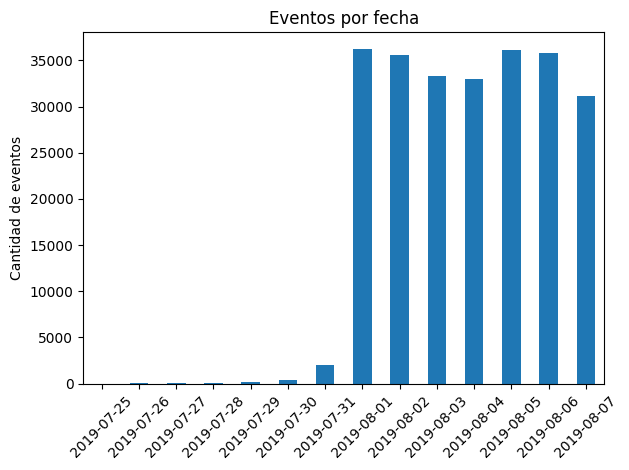

Cut‑off (inicio de datos completos): 2019-07-26
Pérdida relativa de eventos: 0.00%
Pérdida relativa de usuarios: 0.00%
248    85743
246    80300
247    78074
Name: exp_id, dtype: int64


In [4]:
total_events = len(df)
total_users = df['user_id'].nunique()
events_per_user = total_events / total_users

print(f"Eventos totales: {total_events:,}")
print(f"Usuarios únicos: {total_users:,}")
print(f"Promedio de eventos por usuario: {events_per_user:.2f}")

# Rango temporal
min_ts, max_ts = df['event_datetime'].min(), df['event_datetime'].max()
print(f"Periodo: {min_ts}  →  {max_ts}")

# Histograma por fecha
df['event_date'].value_counts().sort_index().plot(kind='bar')
plt.title('Eventos por fecha')
plt.ylabel('Cantidad de eventos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Determinar fecha de datos completos 
daily_counts = df.groupby('event_date')['user_id'].nunique()
cutoff_date = daily_counts[daily_counts > daily_counts.quantile(0.05)].index.min()
print(f"Cut‑off (inicio de datos completos): {cutoff_date}")

df_clean = df[df['event_date'] >= cutoff_date]
lost_events = 1 - len(df_clean)/len(df)
lost_users = 1 - df_clean['user_id'].nunique()/df['user_id'].nunique()
print(f"Pérdida relativa de eventos: {lost_events:.2%}")
print(f"Pérdida relativa de usuarios: {lost_users:.2%}")

# Comprobar experimentos presentes
print(df_clean['exp_id'].value_counts())

In [5]:
#evento mas popular 
evento_popular = df["event"].value_counts().idxmax()
print("Evento más popular:", evento_popular)
#Usuarios que realizaron este evento por grupo
usuarios_evento = (
    df[df["event"] == evento_popular]
    .groupby("exp_id")["user_id"]
    .nunique()
)
print(usuarios_evento)
#proporcion de usuarios 
usuarios_totales = df.groupby("exp_id")["user_id"].nunique()
proporcion = usuarios_evento / usuarios_totales
print(proporcion)

Evento más popular: MainScreenAppear
exp_id
246    2456
247    2482
248    2501
Name: user_id, dtype: int64
exp_id
246    0.986742
247    0.984921
248    0.983871
Name: user_id, dtype: float64


In [6]:
## Definición preliminar del embudo
# Seleccionamos los eventos clave más frecuentes de la app
event_freq = df_clean['event'].value_counts()
display(event_freq.head(10))

funnel_events = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']
print("Embudo propuesto:", ' → '.join(funnel_events))

# Cantidad de usuarios por evento
users_by_event = df_clean.groupby('event')['user_id'].nunique().loc[funnel_events]
display(users_by_event)

# Proporciones de retención por etapa
retention = users_by_event.shift(0) / users_by_event.shift(1)
retention.iloc[0] = 1.0  # Primera etapa
cum_conv = users_by_event / users_by_event.iloc[0]

funnel_df = pd.DataFrame({
    'usuarios': users_by_event,
    'retencion': retention,
    'conversion_acumulada': cum_conv
})
display(funnel_df)

# Etapa con mayor pérdida
max_drop_stage = retention[1:].idxmin()
print(f"Mayor pérdida entre: {max_drop_stage}")

# Porcentaje de usuarios que llegan a pago
print(f"Conversión total a pago: {cum_conv.iloc[-1]:.2%}")

MainScreenAppear           119201
OffersScreenAppear          46824
CartScreenAppear            42729
PaymentScreenSuccessful     34311
Tutorial                     1052
Name: event, dtype: int64

Embudo propuesto: MainScreenAppear → OffersScreenAppear → CartScreenAppear → PaymentScreenSuccessful


event
MainScreenAppear           7439
OffersScreenAppear         4613
CartScreenAppear           3749
PaymentScreenSuccessful    3547
Name: user_id, dtype: int64

,usuarios,retencion,conversion_acumulada
event,,,
MainScreenAppear,7439,1.000000,1.000000
OffersScreenAppear,4613,0.620110,0.620110
CartScreenAppear,3749,0.812703,0.503966
PaymentScreenSuccessful,3547,0.946119,0.476811


Mayor pérdida entre: OffersScreenAppear
Conversión total a pago: 47.68%


In [7]:
## Funciones de ayuda
def proportion_test(success_a, total_a, success_b, total_b, alpha=0.05):
    stat, pval = proportions_ztest([success_a, success_b], [total_a, total_b])
    return pval < alpha, pval

def event_proportion(df, event, group):
    grp_df = df[(df['exp_id']==group)]
    users_total = grp_df['user_id'].nunique()
    users_event = grp_df.loc[grp_df['event']==event, 'user_id'].nunique()
    return users_event, users_total

alpha = 0.05  # Nivel de significancia base

groups = [246, 247, 248]
events = df_clean['event'].unique()

print("Usuarios por grupo:")
for g in groups:
    print(f"Grupo {g}: {df_clean[df_clean['exp_id']==g]['user_id'].nunique():,}")

### 5.1  Comparación grupos A (246 vs 247)
aa_results = []
for ev in events:
    succ1, tot1 = event_proportion(df_clean, ev, 246)
    succ2, tot2 = event_proportion(df_clean, ev, 247)
    sig, p = proportion_test(succ1, tot1, succ2, tot2, alpha)
    aa_results.append((ev, succ1/tot1 if tot1 else 0, succ2/tot2 if tot2 else 0, p, sig))
aa_df = pd.DataFrame(aa_results, columns=['event', 'rate_246', 'rate_247', 'p_value', 'significant'])
display(aa_df.sort_values('p_value').head())

### 5.2  Comparación grupo B (248) con control combinado (246+247)
control_df = df_clean[df_clean['exp_id'].isin([246,247])]
control_users = control_df['user_id'].nunique()
test_results = []
for ev in events:
    succ_test, tot_test = event_proportion(df_clean, ev, 248)
    succ_ctrl = control_df.loc[control_df['event']==ev, 'user_id'].nunique()
    sig, p = proportion_test(succ_ctrl, control_users, succ_test, tot_test, alpha)
    test_results.append((ev, succ_ctrl/control_users if control_users else 0,
                         succ_test/tot_test if tot_test else 0, p, sig))
test_df = pd.DataFrame(test_results, columns=['event', 'rate_control', 'rate_248', 'p_value', 'significant'])
display(test_df.sort_values('p_value').head())

Usuarios por grupo:
Grupo 246: 2,489
Grupo 247: 2,520
Grupo 248: 2,542


,event,rate_246,rate_247,p_value,significant
3,PaymentScreenSuccessful,0.482925,0.460317,0.109025,False
1,CartScreenAppear,0.510245,0.492063,0.198175,False
2,OffersScreenAppear,0.620731,0.607143,0.323323,False
0,MainScreenAppear,0.986742,0.984921,0.585664,False
4,Tutorial,0.112093,0.113492,0.875657,False


,event,rate_control,rate_248,p_value,significant
1,CartScreenAppear,0.501098,0.487411,0.260981,False
2,OffersScreenAppear,0.613895,0.605035,0.455540,False
0,MainScreenAppear,0.985826,0.983871,0.506713,False
3,PaymentScreenSuccessful,0.471551,0.466168,0.657843,False
4,Tutorial,0.112797,0.110936,0.808687,False


In [8]:
## Corrección por pruebas múltiples (Bonferroni)
m = len(events)  # número de pruebas
alpha_bonf = alpha / m
print(f"Nivel corregido Bonferroni: {alpha_bonf:.4f}")

sig_events = test_df[test_df['p_value'] < alpha_bonf]
print("Eventos con diferencia significativa tras corrección:")
display(sig_events)

### Conclusiones
print("""1. Los grupos de control 246 y 247 %s diferencias significativas.
2. Para el cambio de fuentes (grupo 248), %s diferencias estadísticamente significativas frente al control combinado al nivel Bonferroni‑corregido (%.4f).
"""
%('NO presentan' if aa_df['significant'].sum()==0 else 'presentan',
  'NO se detectaron' if sig_events.empty else 'SE detectaron',
  alpha_bonf))

Nivel corregido Bonferroni: 0.0100
Eventos con diferencia significativa tras corrección:


,event,rate_control,rate_248,p_value,significant


1. Los grupos de control 246 y 247 NO presentan diferencias significativas.
2. Para el cambio de fuentes (grupo 248), NO se detectaron diferencias estadísticamente significativas frente al control combinado al nivel Bonferroni‑corregido (0.0100).

